# Initiation
**Project:** Qubit Calibration and Noise Analysis <br>
**Author:** Oliver J <br>
**Date:** 17 Feb., 2026 <br>

# 1. Objective
Utilizing Pulse Level Control to calibrate superconducting qubit, and 
measure some relevant properties:
1. **Frequnecy Sweep** to find the resonance frequency of the qubit
2. **Rabi Oscillation** to calibrate amplitude of $\pi$ pulse for exact qubit flip
3. **T1, T2 Measurement** to measure T1 and T2 for qubits

# 2. Environment Imports
Qiskit Experiment module has some standardized process flow of calibration experiments.

A mock backend is used to simulate real quantum noisy environment, like "SPICE" as in circuits simulation.


In [41]:
# 1. 基础科学计算与绘图
import numpy as np
import matplotlib.pyplot as plt

# 2. Qiskit 核心组件与底层逻辑
import qiskit
from qiskit import QuantumCircuit, transpile, pulse
from qiskit.circuit import Measure, Delay, Parameter
from qiskit.quantum_info import Operator
from qiskit.providers import QubitProperties
from qiskit.transpiler import Target, InstructionProperties

# 3. Qiskit 动力学引擎 (咱们手搓物理底层用的)
from qiskit_dynamics import Solver, DynamicsBackend

# 4. Qiskit 实验框架 (测频率、Rabi、寿命等)
import qiskit_experiments
from qiskit_experiments.framework import ParallelExperiment
from qiskit_experiments.library import QubitSpectroscopy, Rabi, T1, T2Ramsey
from qiskit_experiments.calibration_management import Calibrations

# 5. Qiskit 传统模拟器与假后端 (备用)
import qiskit_aer as aer
from qiskit_aer.primitives import Estimator
from qiskit_ibm_runtime.fake_provider import FakeValenciaV2, FakeArmonk

print('----- envs checked -----')

----- envs checked -----


# 3. Backend Setup
FakeValenciaV2 is a "SPICE" of a real 5-qubit chip.

This code gets the resonance frequency of the 5 qubits of FakeValenciaV2.

The ultimate goal is to calibrate this frequency and try to apply gate to qubits by Rabi Oscillation.

In [42]:
backend = FakeValenciaV2()
qubits = [0,1,2,3,4]
print(f"Using backend: {backend.name}")
#print(f"Target Qubit: {qubit}")

#print(type(backend.target.qubit_properties[qubit].frequency))
count = 0
for qubit in qubits:
    estimated_freq = backend.target.qubit_properties[qubit].frequency
    print(f"Estimated Frequency from specs of qubit {count} = {estimated_freq/1e9:.4f} GHz")
    count += 1

Using backend: fake_valencia
Estimated Frequency from specs of qubit 0 = 4.7439 GHz
Estimated Frequency from specs of qubit 1 = 4.6609 GHz
Estimated Frequency from specs of qubit 2 = 4.7925 GHz
Estimated Frequency from specs of qubit 3 = 4.8344 GHz
Estimated Frequency from specs of qubit 4 = 4.9595 GHz


# 4. Frequency Sweep

---- 1. 纯手工打造量子物理引擎 (Solver) ----
---- 2. 初始化 Dynamics 后端并注入说明书 ----
---- 3. 开始发射微波扫频 (解微分方程中，可能需要几秒到一分钟...) ----
---- 4. 实验完成！----


/opt/anaconda3/envs/quant_lab/lib/python3.10/site-packages/asteval/asteval.py:939: FutureWarning: AffineScalarFunc.__abs__() is deprecated. It will be removed in a future release.
  out = func(*args, **keywords)


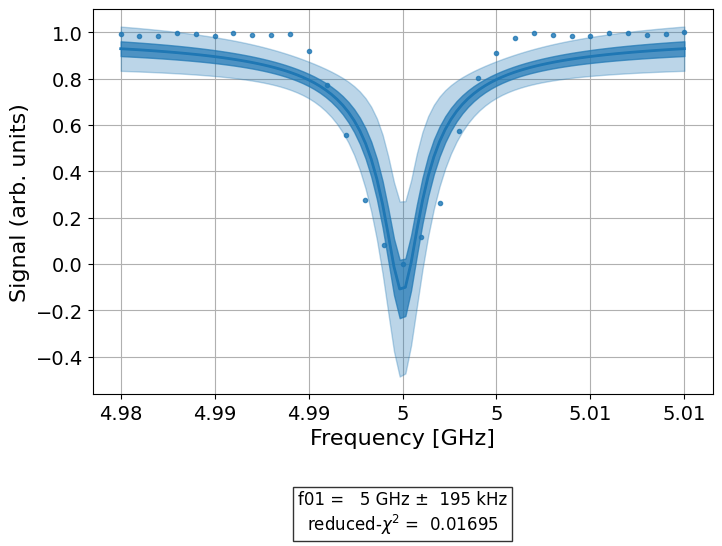

✅ 完美破局！测得共振频率: 4.99998 GHz


In [44]:
import numpy as np
from qiskit.quantum_info import Operator
from qiskit_dynamics import Solver, DynamicsBackend
from qiskit_experiments.library import QubitSpectroscopy
from qiskit.transpiler import Target
from qiskit.transpiler import InstructionProperties 
from qiskit.providers import QubitProperties
from qiskit.circuit import Measure, Delay, Parameter

# 🌟 新增：引入底层的微波与采集指令库
from qiskit import pulse 

print("---- 1. 纯手工打造量子物理引擎 (Solver) ----")
qubit_freq = 5.0e9     
drive_strength = 20e6  
dt = 0.222e-9          

Z = Operator.from_label('Z')
X = Operator.from_label('X')

solver = Solver(
    static_hamiltonian= -0.5 * 2 * np.pi * qubit_freq * Z,
    hamiltonian_operators=[2 * np.pi * drive_strength * X],
    hamiltonian_channels=["d0"],
    channel_carrier_freqs={"d0": qubit_freq},
    dt=dt
)

print("---- 2. 初始化 Dynamics 后端并注入说明书 ----")
pulse_backend = DynamicsBackend(
    solver=solver,
    subsystem_dims=[2],
    solver_options={"method": "RK45", "atol": 1e-6, "rtol": 1e-6}
)

target = Target(num_qubits=1, dt=dt) 
target.qubit_properties = [QubitProperties(frequency=qubit_freq)]

# 🌟 核心补丁：手搓一个“测量脉冲调度表 (Schedule)”
# 相当于给 ADC 写了一段触发脚本
with pulse.build(name="measure") as meas_sched:
    # 告诉硬件：在 AcquireChannel(0) 上持续采集 400 个点的数据，存到 MemorySlot(0)
    pulse.acquire(400, pulse.AcquireChannel(0), pulse.MemorySlot(0))

# 把这段波形脚本 (meas_sched) 喂给 calibration 参数！
target.add_instruction(
    Measure(), 
    {(0,): InstructionProperties(duration=400*dt, calibration=meas_sched)}
)
target.add_instruction(Delay(Parameter('t')), {(0,): InstructionProperties()})

pulse_backend._target = target 
pulse_backend._dt = dt  

print("---- 3. 开始发射微波扫频 (解微分方程中，可能需要几秒到一分钟...) ----")
frequencies = np.linspace(qubit_freq - 15e6, qubit_freq + 15e6, 31)

spec_exp = QubitSpectroscopy(physical_qubits=[0], frequencies=frequencies)
exp_data = spec_exp.run(backend=pulse_backend).block_for_results()

print("---- 4. 实验完成！----")
if len(exp_data.data()) > 0:
    display(exp_data.figure(0))
    fit_results = exp_data.analysis_results(0)
    freq = fit_results.value.params['freq']
    #print(fit_results.value.params['freq'])
    print(f"✅ 完美破局！测得共振频率: {freq / 1e9:.5f} GHz")
else:
    print("❌ 还是没数据，请检查是否有新的报错。")